***
### Import of required libraries
***

In [17]:
from traffic.core import Traffic
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

***
#### Import and preparation of data
***

##### Trajectory data

In [18]:
# Path to folder containing traffic files
traj_path = "/store/Projects_CRM/RAD_paper/RAD_new_data/trajectories/"

# Definition of relevant city pairs
pairs = [
    ("EGKK", "LSZH", "london_to_zurich_EGKK.parquet"),
    ("EGLC", "LSZH", "london_to_zurich_EGLC.parquet"),
    ("EGLL", "LSZH", "london_to_zurich_EGLL.parquet"),
    ("LSZH", "EGKK", "zurich_to_london_EGKK.parquet"),
    ("LSZH", "EGLC", "zurich_to_london_EGLC.parquet"),
    ("LSZH", "EGLL", "zurich_to_london_EGLL.parquet"),
]

# Generation of dataframe containing flight_id, callsign and date over all
# flights for all city pairs
dfs = []
for pair in pairs:
    print(f"processing {pair[0]} -> {pair[1]}")
    flights = Traffic.from_file(traj_path + pair[2])
    flight_ids = []
    callsigns = []
    dates = []
    for flight in flights:
        flight_ids.append(flight.flight_id)
        callsigns.append(flight.callsign)
        dates.append(flight.start.date())
    df = pd.DataFrame(
        {
            "flight_id": flight_ids,
            "callsign": callsigns,
            "date": dates,
        }
    )
    dfs.append(df)
osn_df = pd.concat(dfs)

processing EGKK -> LSZH
processing EGLC -> LSZH
processing EGLL -> LSZH
processing LSZH -> EGKK
processing LSZH -> EGLC
processing LSZH -> EGLL


##### Flightplan data

In [19]:
# Load flightplan data
flightplan_path = (
    "/store/Projects_CRM/RAD_paper/RAD_new_data/flightplans_complete.parquet"
)
flightplans = pd.read_parquet(flightplan_path)
flightplans = flightplans[flightplans["operator"].isin(["SWR", "BAW", "EZY"])]

# Generate a dataframe containing identifier, callsign and date for all flights
# contained in the flightplan data
ids = flightplans.identifier.unique()
identifiers = []
callsigns = []
dates = []
times = []
for id in tqdm(ids):
    temp = flightplans[flightplans.identifier == id]
    identifiers.append(temp.iloc[0].identifier)
    callsigns.append(temp.iloc[0].callsign)
    dates.append(temp.iloc[0].segment_start_d)
    times.append(temp.iloc[0].segment_start_t)
flightplans_df = pd.DataFrame(
    {
        "identifier": identifiers,
        "callsign": callsigns,
        "date": dates,
        "time": times,
    }
)
flightplans_df

  0%|          | 0/4987 [00:00<?, ?it/s]

,identifier,callsign,date,time
0,271656154,SWR81C,2024-05-01,05:14:00
1,271656552,BAW709,2024-05-01,05:20:00
2,271656580,SWR188L,2024-05-01,05:31:00
3,271657131,BAW710R,2024-05-01,05:46:00
4,271657573,SWR40T,2024-05-01,06:09:00
...,...,...,...,...
4982,277035880,SWR693P,2024-09-30,19:10:00
4983,277036569,SWR24C,2024-09-30,19:19:00
4984,277036744,SWR339,2024-09-30,19:42:00
4985,277038044,BAW719,2024-09-30,20:16:00


***
### Data matching
***

##### Matching dataframe matching identifier and flight_id based on callsign and date

In [20]:
match_df = pd.merge(
    left=flightplans_df,
    right=osn_df,
    left_on=["date", "callsign"],
    right_on=["date", "callsign"],
    how="inner",
)
match_df

,identifier,callsign,date,time,flight_id
0,271656154,SWR81C,2024-05-01,05:14:00,SWR81C_1201
1,271656552,BAW709,2024-05-01,05:20:00,BAW709_655
2,271657573,SWR40T,2024-05-01,06:09:00,SWR40T_1681
3,271658095,EZY12FZ,2024-05-01,06:47:00,EZY12FZ_371
4,271659167,SWR3EZ,2024-05-01,07:12:00,SWR3EZ_1337
...,...,...,...,...,...
3532,277035420,EZY82UF,2024-09-30,18:55:00,EZY82UF_312
3533,277035676,BAW720T,2024-09-30,19:00:00,BAW720T_015
3534,277036569,SWR24C,2024-09-30,19:19:00,SWR24C_1240
3535,277036744,SWR339,2024-09-30,19:42:00,SWR339_2515


##### Grouping multiple flights per combination of callsign and date

In [21]:
match_df = (
    match_df.groupby(["date", "callsign"], as_index=False)
    .agg(
        {
            "flight_id": lambda x: tuple(x),
            "identifier": "first",
        }
    )
    .drop(columns=["date", "callsign"])
)
match_df

,flight_id,identifier
0,"(BAW709_655,)",271656552
1,"(BAW712T_692,)",271661068
2,"(BAW714T_588,)",271666215
3,"(BAW715T_552,)",271670282
4,"(BAW718_258,)",271673308
...,...,...
3518,"(SWR81C_1379,)",277010771
3519,"(SWR8DT_2069,)",277014093
3520,"(SWR8LX_2494,)",277016582
3521,"(SWR9YF_1579,)",277021623


##### Add flight_id to flightplan

In [22]:
flightplans = pd.merge(
    left=flightplans,
    right=match_df,
    left_on="identifier",
    right_on="identifier",
    how="left",
)

##### Remove flights without assigned trajectories

In [23]:
print(flightplans.identifier.nunique())
flightplans = flightplans.dropna(subset=["flight_id"])
flightplans.identifier.nunique()

4987


3523

##### Remove flight without unique assignment

In [24]:
print(flightplans.identifier.nunique())
flightplans = flightplans[flightplans["flight_id"].apply(lambda x: len(x) == 1)]
print(flightplans.identifier.nunique())

3523
3513


##### Save

In [25]:
flightplans.to_parquet(
    "/store/Projects_CRM/RAD_paper/RAD_new_data/flightplans_complete_with_flight_id.parquet"
)

***
### Analysis
***

In [26]:
flightplans = pd.read_parquet(
    "/store/Projects_CRM/RAD_paper/RAD_new_data/flightplans_complete_with_flight_id.parquet"
)

In [27]:
flightplans_grouped = flightplans.groupby("identifier").agg(
    {
        "origin": "first",
        "destination": "first",
        "operator": "first",
        "ac_type": "first",
        "segment_start_d": "first",
        "segment_start_t": "first",
    }
)

##### Amount per route

In [28]:
print(
    f"LSZH -> EGKK: {len(flightplans_grouped[(flightplans_grouped.origin == 'LSZH')&(flightplans_grouped.destination == 'EGKK')])}"
)
print(
    f"EGKK -> LSZH: {len(flightplans_grouped[(flightplans_grouped.origin == 'EGKK')&(flightplans_grouped.destination == 'LSZH')])}"
)
print(
    f"LSZH -> EGLC: {len(flightplans_grouped[(flightplans_grouped.origin == 'LSZH')&(flightplans_grouped.destination == 'EGLC')])}"
)
print(
    f"EGLC -> LSZH: {len(flightplans_grouped[(flightplans_grouped.origin == 'EGLC')&(flightplans_grouped.destination == 'LSZH')])}"
)
print(
    f"LSZH -> EGLL: {len(flightplans_grouped[(flightplans_grouped.origin == 'LSZH')&(flightplans_grouped.destination == 'EGLL')])}"
)
print(
    f"EGLL -> LSZH: {len(flightplans_grouped[(flightplans_grouped.origin == 'EGLL')&(flightplans_grouped.destination == 'LSZH')])}"
)

LSZH -> EGKK: 264
EGKK -> LSZH: 326
LSZH -> EGLC: 274
EGLC -> LSZH: 388
LSZH -> EGLL: 887
EGLL -> LSZH: 1374


##### Amount per airline

In [29]:
print(f"SWR: {len(flightplans_grouped[flightplans_grouped.operator == 'SWR'])}")
print(f"BAW: {len(flightplans_grouped[flightplans_grouped.operator == 'BAW'])}")
print(f"EZY: {len(flightplans_grouped[flightplans_grouped.operator == 'EZY'])}")

SWR: 2362
BAW: 765
EZY: 386


##### Amount per type

In [30]:
flightplans_grouped.ac_type.value_counts()

ac_type
BCS3    693
BCS1    504
A319    490
A320    473
A20N    444
A21N    350
E290    292
E295    128
E190     79
A321     45
E195     15
Name: count, dtype: int64

##### Distribution over time

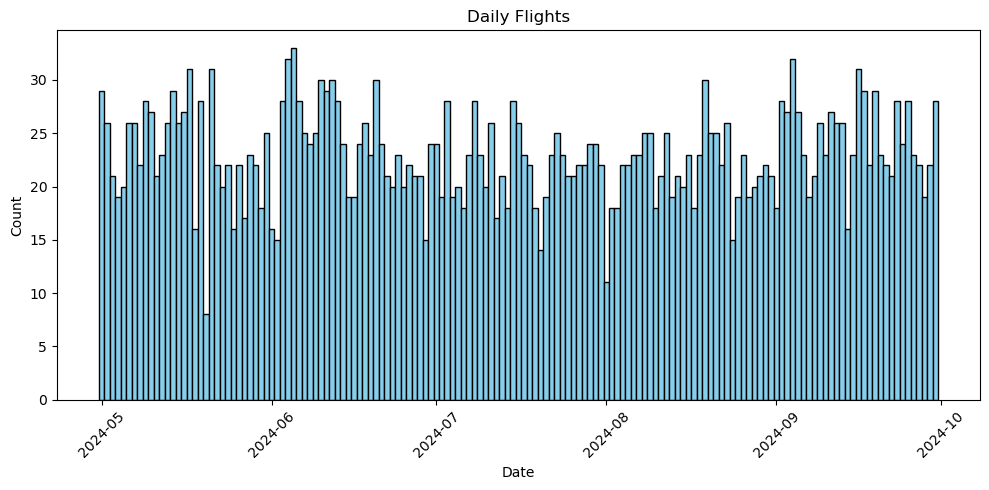

In [31]:
date_grouped = (
    flightplans_grouped.groupby(flightplans_grouped["segment_start_d"])
    .size()
    .reset_index(name="count")
)

plt.figure(figsize=(10, 5))
plt.bar(
    date_grouped["segment_start_d"],
    date_grouped["count"],
    width=1.0,
    color="skyblue",
    edgecolor="black",
)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Daily Flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Percentage of available flightplans

In [32]:
full_flightplan = pd.read_parquet(
    "/store/Projects_CRM/RAD_paper/RAD_new_data/flightplans_complete.parquet"
)
full_flightplan = full_flightplan[
    full_flightplan["operator"].isin(["SWR", "BAW", "EZY"])
]
full_flightplan = full_flightplan.groupby("identifier").agg(
    {
        "origin": "first",
        "destination": "first",
    }
)
reduced = pd.read_parquet(
    "/store/Projects_CRM/RAD_paper/RAD_new_data/flightplans_complete_with_flight_id.parquet"
)
reduced = reduced.groupby("identifier").agg(
    {
        "origin": "first",
        "destination": "first",
    }
)

print(
    f"LSZH -> EGKK: {round(100*len(reduced[(reduced.origin == 'LSZH')&(reduced.destination == 'EGKK')])/len(full_flightplan[(full_flightplan.origin == 'LSZH')&(full_flightplan.destination == 'EGKK')]),1)}%"
)
print(
    f"EGKK -> LSZH: {round(100*len(reduced[(reduced.origin == 'EGKK')&(reduced.destination == 'LSZH')])/len(full_flightplan[(full_flightplan.origin == 'EGKK')&(full_flightplan.destination == 'LSZH')]),1)}%"
)
print(
    f"LSZH -> EGLC: {round(100*len(reduced[(reduced.origin == 'LSZH')&(reduced.destination == 'EGLC')])/len(full_flightplan[(full_flightplan.origin == 'LSZH')&(full_flightplan.destination == 'EGLC')]),1)}%"
)
print(
    f"EGLC -> LSZH: {round(100*len(reduced[(reduced.origin == 'EGLC')&(reduced.destination == 'LSZH')])/len(full_flightplan[(full_flightplan.origin == 'EGLC')&(full_flightplan.destination == 'LSZH')]),1)}%"
)
print(
    f"LSZH -> EGLL: {round(100*len(reduced[(reduced.origin == 'LSZH')&(reduced.destination == 'EGLL')])/len(full_flightplan[(full_flightplan.origin == 'LSZH')&(full_flightplan.destination == 'EGLL')]),1)}%"
)
print(
    f"EGLL -> LSZH: {round(100*len(reduced[(reduced.origin == 'EGLL')&(reduced.destination == 'LSZH')])/len(full_flightplan[(full_flightplan.origin == 'EGLL')&(full_flightplan.destination == 'LSZH')]),1)}%"
)

LSZH -> EGKK: 66.3%
EGKK -> LSZH: 81.9%
LSZH -> EGLC: 64.0%
EGLC -> LSZH: 91.5%
LSZH -> EGLL: 53.1%
EGLL -> LSZH: 82.4%
